In [1]:
import pypangraph as pp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
from ete3 import Tree
from Bio import SeqIO

In [2]:
# reordering according to list of leaves from Newick tree
t = Tree("data/panaroo70_2.txt")
ordered_names = t.get_leaf_names()
ordered_names.insert(9,"wuj2014")
#ordered_names = np.append(ordered_names, "wuj2014")
print(ordered_names)


['boryong', 'gilliam', 'ta686', 'wgot003', 'tw22', 'ta763', 'karp', 'ut176', 'tw1', 'wuj2014', 'ut76', 'ikeda', 'kato', 'wgot013', 'wgot020', 'wgot001', 'wgot017', 'wgot007', 'wgot031', 'wgot008', 'wgot019', 'wgot015', 'wgot016', 'wgot004', 'wgot005']


In [3]:
print(len(ordered_names))

25


In [7]:
def reorder_fasta(input_file, ordered_names, output_file="reordered_genomes.fasta"):
    # Read all sequences into a dictionary with lowercase keys
    sequences = {}
    for record in SeqIO.parse(input_file, "fasta"):
        # Get the identifier without any description and convert to lowercase
        identifier = record.id.split()[0].lower()
        sequences[identifier] = record

    # Create a list of records in the desired order
    ordered_records = []
    for name in ordered_names:
        name_lower = name.lower()
        if name_lower in sequences:
            ordered_records.append(sequences[name_lower])
        else:
            print(f"Warning: {name} not found in the input FASTA file")

    # Write the reordered sequences to a new file
    SeqIO.write(ordered_records, output_file, "fasta")
    print(f"Reordered sequences written to {output_file}")

In [89]:
reorder_fasta("data/whole_genomes_for_pangraph.fasta", ordered_names, output_file="data/reordered_genomes.fasta")

Reordered sequences written to reordered_genomes.fasta


In [90]:
reorder_fasta("data/IRs_for_pangraph.fasta", ordered_names, output_file="data/reordered_IRs.fasta")

Reordered sequences written to data/reordered_IRs.fasta


In [9]:
reorder_fasta("data/complete_genome_RAGEs.fasta", ordered_names, output_file="data/reordered_RAGEs.fasta")

Reordered sequences written to data/reordered_RAGEs.fasta


# Whole genome

In [115]:
graph = pp.Pangraph.from_json("data/Ot_pangraph_3.json")

In [116]:
print(graph)

pangraph object with 17 paths, 6679 blocks and 137079 nodes


In [128]:
def plot_synteny(graph,block_color=block_color,figsize=(10,6),output_file="synteny_1"):
    path_dict = graph.to_path_dictionary()
    block_stats = graph.to_blockstats_df()
    # dictionary to assign a new random color to each block
    #block_color = defaultdict(lambda: plt.cm.rainbow(np.random.rand()))

    fig, ax = plt.subplots(figsize=figsize)

    y = 0
    for path_name, path in path_dict.items():
        x = 0
        for block_id, block_strand in path:

            L = block_stats.loc[block_id, "len"] # block consensus length
            is_core = block_stats.loc[block_id, "core"]

            # block color
            color = block_color[block_id] if is_core else "lightgray"
            block_color[block_id] = mpl.colors.to_hex(color)

            height = 0.8 if is_core else 0.6 # block thickness

            ax.barh(y, L, left=x, height=height, color=color)

            x += L
        y += 1

    ax.set_yticks(range(len(path_dict)))
    ax.set_yticklabels(path_dict.keys())
    ax.set_xlabel("length (bp)")
    plt.savefig(f"output/{output_file}.pdf",format="pdf")
    plt.show()



In [129]:
def plot_MSU(graph,threshold_len,colormap="rainbow",figsize=(8, 5),output_file_name="MSU_1"):
    MSU_mergers, MSU_paths, MSU_len = pp.minimal_synteny_units(graph, threshold_len)

    cmap = mpl.colormaps[colormap]
    color_generator = (cmap(i / len(MSU_len)) for i in range(len(MSU_len)))
    colors = defaultdict(lambda: next(color_generator))

    fig, ax = plt.subplots(figsize=figsize)

    for i, (iso, path) in enumerate(MSU_paths.items()):
        for j, node in enumerate(path.nodes):
            ax.barh(i, 1, left=j, color=colors[node.id])
            if not node.strand:
                ax.arrow(j + 1, i, -0.8, 0, head_width=0.2, head_length=0.2)

    ax.set_yticks(range(len(MSU_paths)))
    ax.set_yticklabels(list(MSU_paths.keys()))
    plt.title(f"Minimal block size = {threshold_len}bp")
    plt.savefig(f"output/{output_file_name}.pdf",format="pdf")
    plt.show()

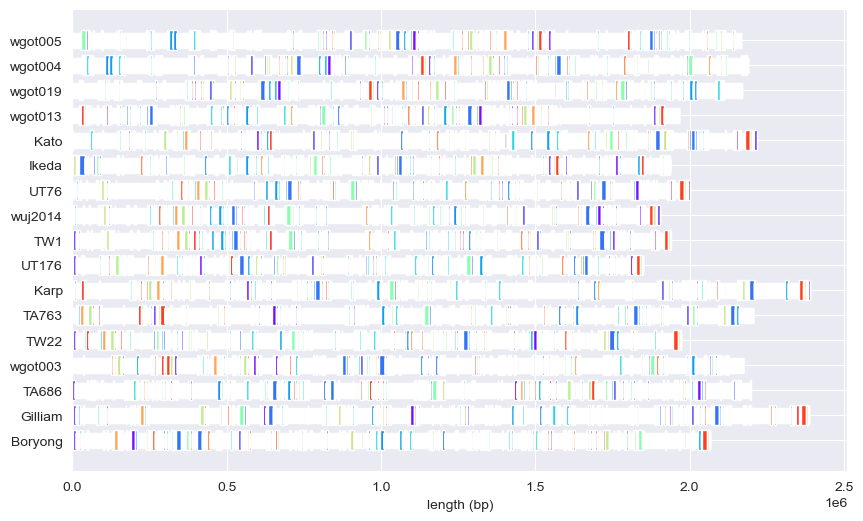

In [119]:
plot_synteny(graph,output_file="reordered_synteny")

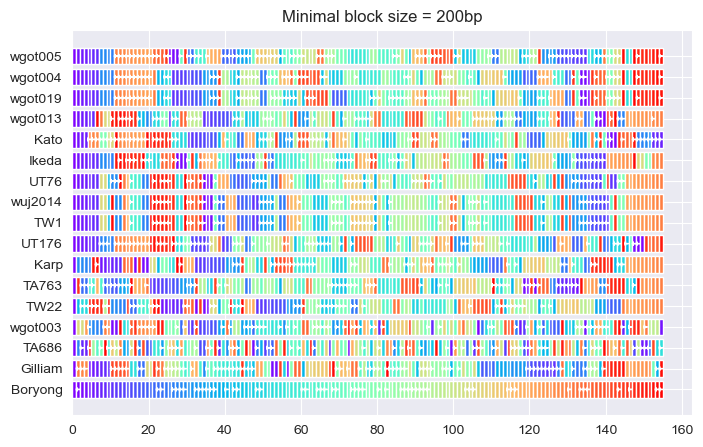

In [132]:
plot_MSU(graph=graph,threshold_len=200, output_file_name="MSU_core100_reordered_min200")

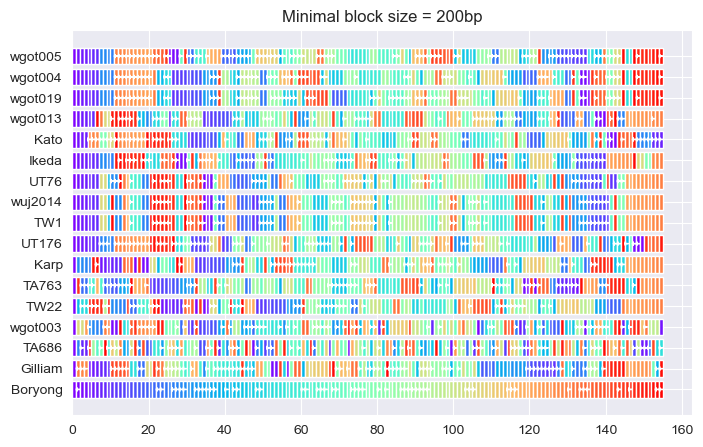

In [120]:
plot_MSU(graph=graph,threshold_len=200,output_file_name="MSU_core100_reordered_min200")

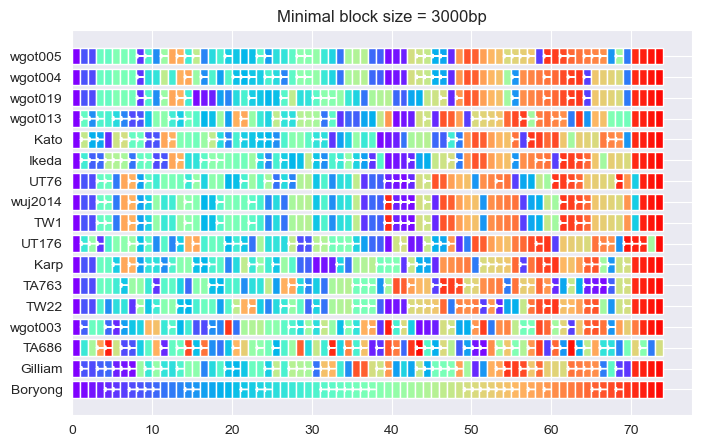

In [121]:
plot_MSU(graph=graph,threshold_len=3000,output_file_name="MSU_core100_reordered_min3000")

# IR

In [110]:
graph_IR = pp.Pangraph.from_json("data/Ot_IR_pangraph_2.json")

In [111]:
print(graph_IR)

pangraph object with 17 paths, 1358 blocks and 8935 nodes


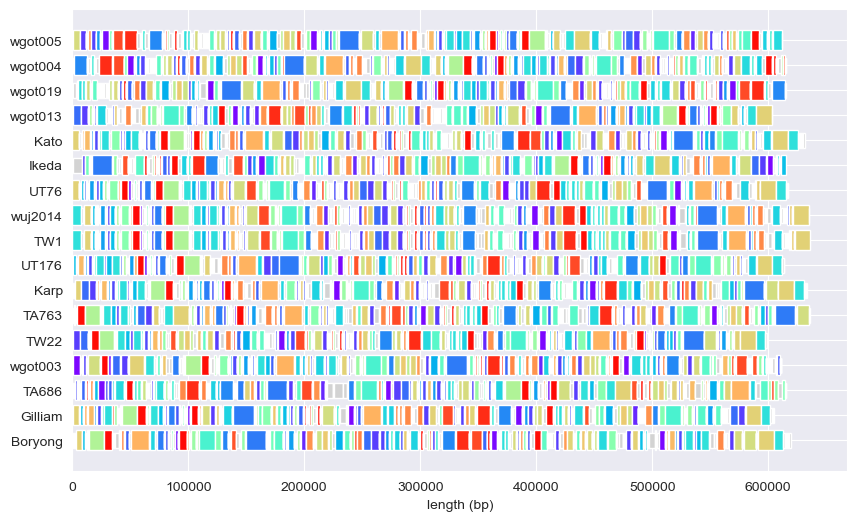

In [112]:
plot_synteny(graph_IR,output_file="reordered_synteny_IR")

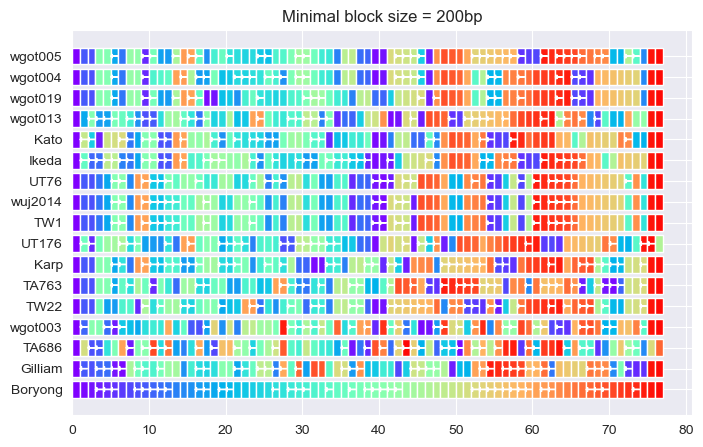

In [113]:
plot_MSU(graph=graph_IR,threshold_len=200,output_file_name="MSU_IR_core100_reordered_min200")

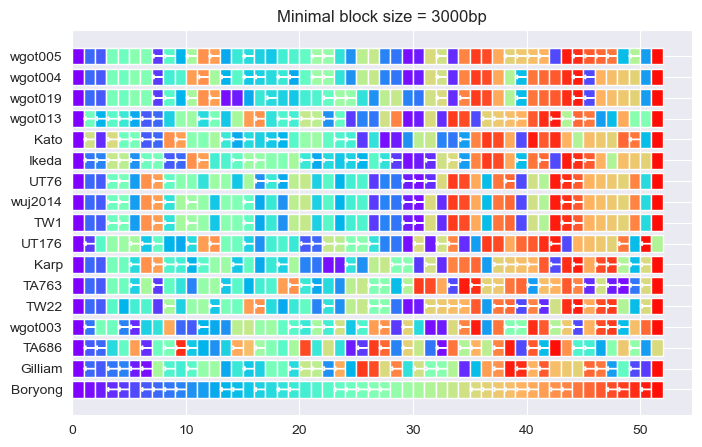

In [114]:
plot_MSU(graph=graph_IR,threshold_len=3000,output_file_name="MSU_IR_core100_reordered_min3000")

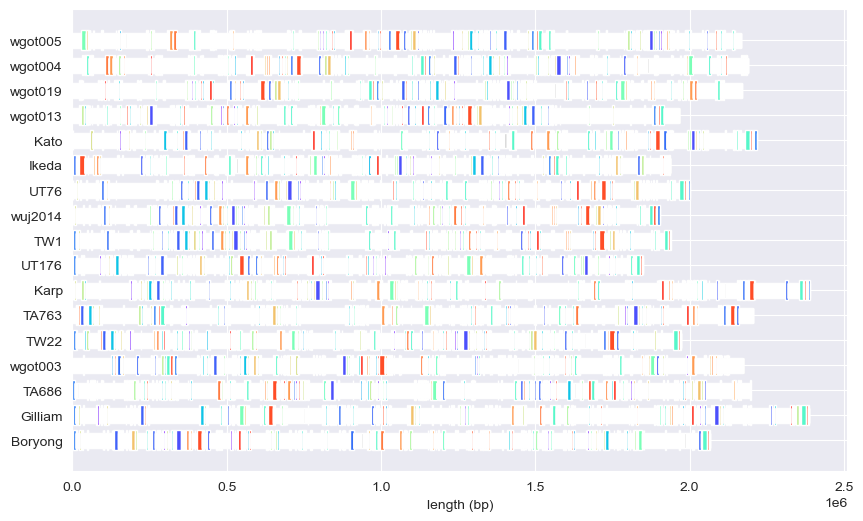

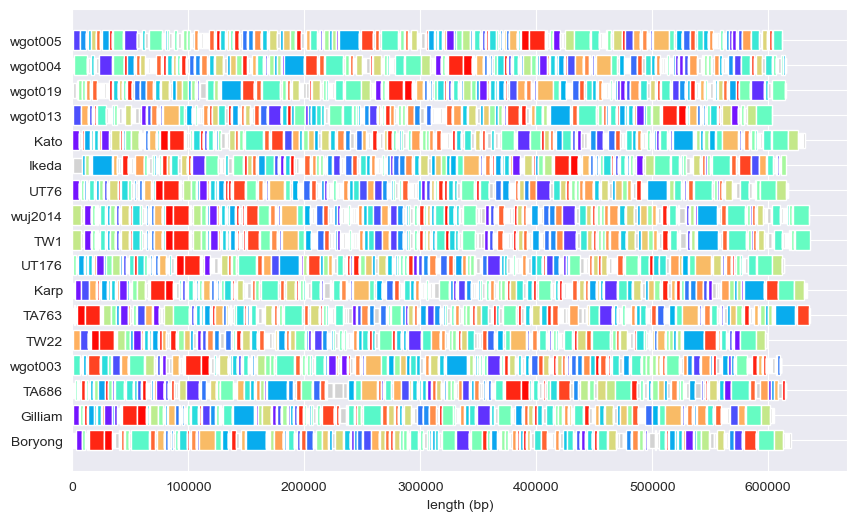

In [131]:
# both at the same time
block_color = defaultdict(lambda: plt.cm.rainbow(np.random.rand()))
plot_synteny(graph,output_file="reordered_synteny")
plot_synteny(graph_IR,output_file="reordered_synteny_IR")


# Changing core thresholds

In [122]:
stats_df = graph.to_blockstats_df()
thresholds_df = stats_df.copy()
thresholds_df["core_95"] = stats_df.n_strains >= 16
thresholds_df["core_90"] = stats_df.n_strains >= 15
thresholds_df["core_80"] = stats_df.n_strains >= 14
thresholds_df["core_75"] = stats_df.n_strains >= 13
thresholds_df["core_70"] = stats_df.n_strains >= 12
print(thresholds_df)

                      count  n_strains  duplicated   core    len  core_95  \
block_id                                                                    
1993343904366055          5          4        True  False    221    False   
3858535113807696         15         15       False  False    147    False   
10595039434352077         5          3        True  False    107    False   
11559188730115725        17         17       False   True  11147     True   
12887796949903306         2          2       False  False    624    False   
...                     ...        ...         ...    ...    ...      ...   
18433948559112443931     15         15       False  False    198    False   
18436256668027666993     38         16        True  False    574     True   
18438212311541566328      6          6       False  False    210    False   
18442230958300184283     15         15       False  False    199    False   
18445216299194943937      3          3       False  False    103    False   

In [123]:
core90_df = stats_df.copy()
core90_df["core"] = thresholds_df["core_90"]
core80_df = stats_df.copy()
core80_df["core"] = thresholds_df["core_80"]
core70_df = stats_df.copy()
core70_df["core"] = thresholds_df["core_70"]
print(core70_df)

                      count  n_strains  duplicated   core    len
block_id                                                        
1993343904366055          5          4        True  False    221
3858535113807696         15         15       False   True    147
10595039434352077         5          3        True  False    107
11559188730115725        17         17       False   True  11147
12887796949903306         2          2       False  False    624
...                     ...        ...         ...    ...    ...
18433948559112443931     15         15       False   True    198
18436256668027666993     38         16        True   True    574
18438212311541566328      6          6       False  False    210
18442230958300184283     15         15       False   True    199
18445216299194943937      3          3       False  False    103

[6679 rows x 5 columns]


In [ ]:
# 90% (15/17)
